#Business Understanding

#Project Domain

Proyek ini berada dalam domain transportasi dan mobilitas perkotaan, dengan fokus pada prediksi volume lalu lintas kendaraan menggunakan pendekatan berbasis data. Prediksi lalu lintas penting untuk mendukung pengambilan keputusan di berbagai sektor seperti pengaturan lalu lintas, perencanaan kota, dan transportasi publik.

#Problem Statements

Kemacetan lalu lintas menjadi tantangan utama di banyak kota besar, menyebabkan pemborosan waktu, bahan bakar, serta menurunkan produktivitas masyarakat. Ketidakefisienan dalam pengaturan sinyal lalu lintas dan tidak tersedianya prediksi volume kendaraan yang akurat menyebabkan lalu lintas tidak terkendali, terutama di titik-titik padat seperti persimpangan. Hal ini berdampak buruk pada ekonomi dan lingkungan.

#Goals

Membangun model prediksi lalu lintas yang mampu memperkirakan jumlah kendaraan yang melewati persimpangan tertentu pada waktu-waktu tertentu berdasarkan data historis. Model ini akan mendukung sistem pengambilan keputusan seperti penyesuaian lampu lalu lintas secara dinamis dan perencanaan infrastruktur jalan yang lebih baik. Aplikasi antarmuka juga dapat dikembangkan untuk memvisualisasikan hasil prediksi agar dapat digunakan oleh pemangku kepentingan secara intuitif.



#Import Library 

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Nadam, Adam
from tensorflow.keras.optimizers import AdamW


In [43]:
# Load data
df = pd.read_csv("traffic.csv")
df.head() #Menampilkan lima baris pertama dari DataFrame

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


#EDA

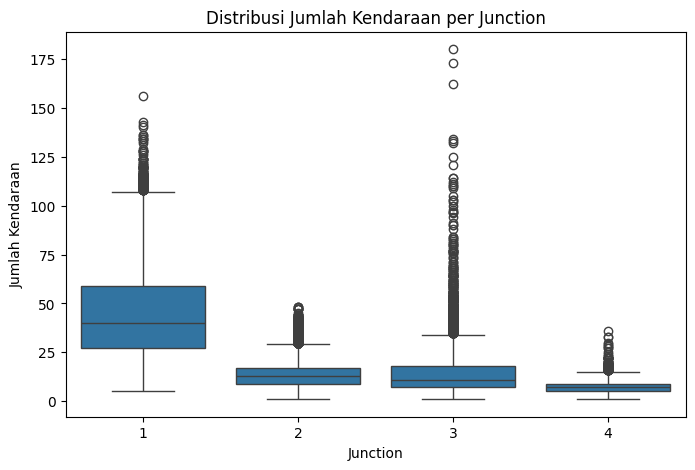

In [44]:
# Plot distribusi kendaraan per junction
plt.figure(figsize=(8,5))
sns.boxplot(x='Junction', y='Vehicles', data=df)
plt.title("Distribusi Jumlah Kendaraan per Junction")
plt.ylabel("Jumlah Kendaraan")
plt.xlabel("Junction")
plt.show()

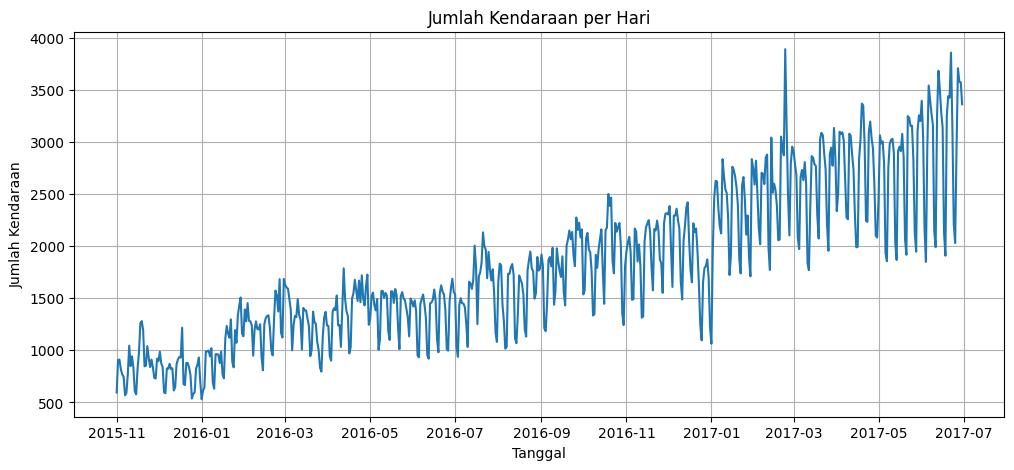

In [45]:
# Ubah kolom DateTime menjadi datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Agregasi jumlah kendaraan per hari
daily_traffic = df.groupby(df['DateTime'].dt.date)['Vehicles'].sum()

# Plot
plt.figure(figsize=(12,5))
daily_traffic.plot()
plt.title("Jumlah Kendaraan per Hari")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Kendaraan")
plt.grid(True)
plt.show()


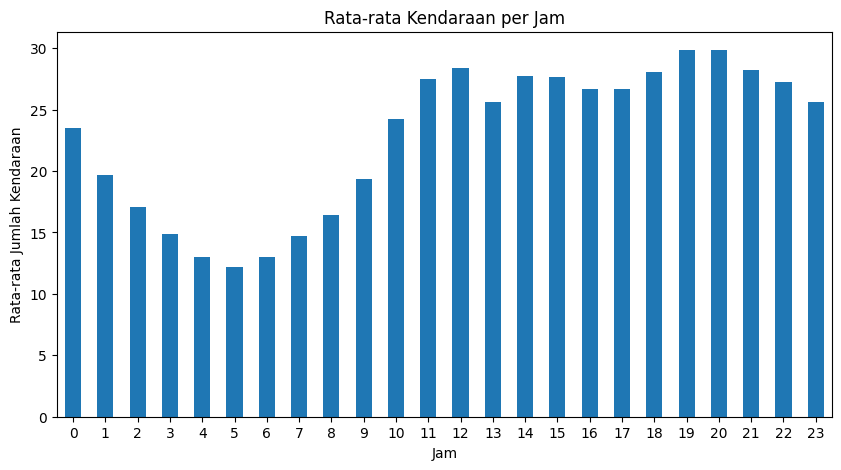

In [46]:
# Ekstrak jam
df['Hour'] = df['DateTime'].dt.hour

# Hitung rata-rata kendaraan per jam
hourly_avg = df.groupby('Hour')['Vehicles'].mean()

# Plot
plt.figure(figsize=(10,5))
hourly_avg.plot(kind='bar')
plt.title("Rata-rata Kendaraan per Jam")
plt.xlabel("Jam")
plt.ylabel("Rata-rata Jumlah Kendaraan")
plt.xticks(rotation=0)
plt.show()

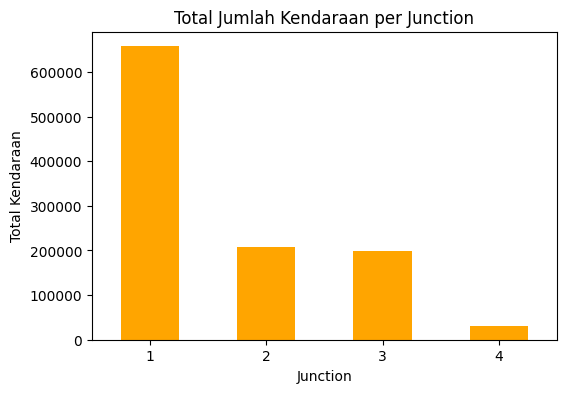

In [47]:
total_vehicles_junction = df.groupby('Junction')['Vehicles'].sum()

# Plot
plt.figure(figsize=(6,4))
total_vehicles_junction.plot(kind='bar', color='orange')
plt.title("Total Jumlah Kendaraan per Junction")
plt.xlabel("Junction")
plt.ylabel("Total Kendaraan")
plt.xticks(rotation=0)
plt.show()

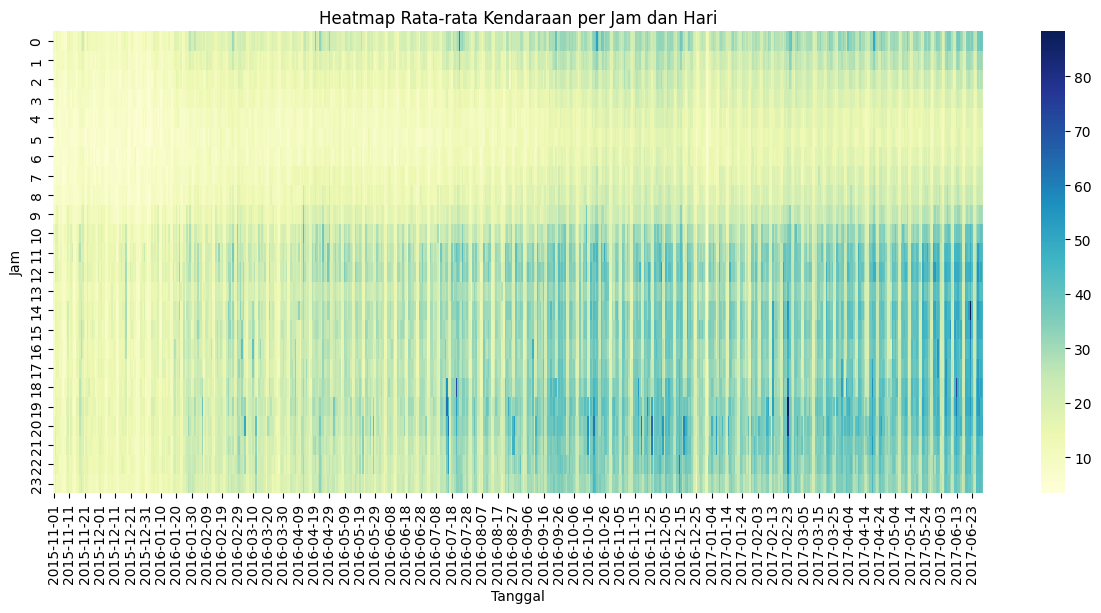

In [48]:
# Ekstrak hari dan jam
df['Day'] = df['DateTime'].dt.date
df['Hour'] = df['DateTime'].dt.hour

# Buat pivot table
pivot = df.pivot_table(values='Vehicles', index='Hour', columns='Day', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(15,6))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title("Heatmap Rata-rata Kendaraan per Jam dan Hari")
plt.xlabel("Tanggal")
plt.ylabel("Jam")
plt.show()

#Data Understanding

In [49]:
#Jumlah data, Jumlah kolom
df.shape

(48120, 6)

In [50]:
# Memberikan informasi ringkas tentang dataset, termasuk jumlah baris dan kolom,
# serta tipe data dan jumlah nilai non-null untuk setiap kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
 4   Hour      48120 non-null  int32         
 5   Day       48120 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(3), object(1)
memory usage: 2.0+ MB


In [51]:
# Memberikan informasi untuk mengetahui nama-nama kolom yang ada dalam dataset
df.columns

Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'Hour', 'Day'], dtype='object')

In [52]:
# ringkasan statistik deskriptif untuk kolom-kolom numerik dalam dataset,
# seperti rata-rata, standar deviasi, nilai minimum, kuartil, dan nilai maksimum
df.describe()

,DateTime,Junction,Vehicles,ID,Hour
count,48120,48120.000000,48120.000000,4.812000e+04,48120.000000
mean,2016-09-19 06:03:56.109725696,2.180549,22.791334,2.016330e+10,11.500000
min,2015-11-01 00:00:00,1.000000,1.000000,2.015110e+10,0.000000
25%,2016-04-16 01:45:00,1.000000,9.000000,2.016042e+10,5.750000
50%,2016-09-30 03:30:00,2.000000,15.000000,2.016093e+10,11.500000
75%,2017-02-25 16:00:00,3.000000,29.000000,2.017023e+10,17.250000
max,2017-06-30 23:00:00,4.000000,180.000000,2.017063e+10,23.000000
std,NaN,0.966955,20.750063,5.944854e+06,6.922258


In [53]:
df.dtypes 

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
Hour                 int32
Day                 object
dtype: object

In [54]:
# Memeriksa jumlah data yang duplikat/memiliki kesamaan
df.duplicated().sum()

np.int64(0)

In [55]:
# Memeriksa jumlah data yang bernilai kosong
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
Hour        0
Day         0
dtype: int64

In [56]:
df.dropna(inplace=True) #yang tidak di perlukan di hapus 

In [57]:
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
Hour        0
Day         0
dtype: int64

#Data Split 

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Fungsi untuk split dan normalisasi data
def split_data(test_size, x, y):
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, Y_train, Y_test

# Fungsi untuk membuat dan mengkompilasi model ANN
def init_ann(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(1, activation='linear'))  # Output regresi
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
    return model

# Fungsi untuk mengevaluasi model dan membuat plot

def evaluate_and_plot_regression(model, x_test, y_test, model_name, title, history, x_train, y_train):
    y_pred = model.predict(x_test).flatten()
    y_test = np.array(y_test).flatten()

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name} Evaluation on Test Data:")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    plt.xlabel("Actual Vehicles")
    plt.ylabel("Predicted Vehicles")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\n{model_name} Training Data Size: {len(x_train)}")
    print(f"{model_name} Final Training Loss (MSE): {history.history['loss'][-1]:.4f}")
    print(f"{model_name} Final Validation Loss (MSE): {history.history['val_loss'][-1]:.4f}")
    print(f"{model_name} Final Training MAE: {history.history['mae'][-1]:.4f}")
    print(f"{model_name} Final Validation MAE: {history.history['val_mae'][-1]:.4f}")



#Modelling

In [73]:
def optimizer():
    sgd = SGD(learning_rate=0.005, momentum=0.5, nesterov=True)
    rms = RMSprop()
    nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    adam = Adam()
    adamW = AdamW(learning_rate=0.002, weight_decay=0.001, beta_1=0.9, beta_2=0.999)
    return sgd, rms, nadam, adamW, adam

# Visualisasi proporsi data

def plot_data_split_pie(train_size, test_size_count, test_size):
    sizes = [train_size, test_size_count]
    labels = ['Data Latih', 'Data Uji']

    fig = px.pie(values=sizes, names=labels, title='Proporsi Data Latih dan Data Uji',
                 hover_data={'values': sizes}, labels={'values': 'Jumlah'})
    fig.update_traces(textinfo='percent+label', hovertemplate='Jumlah: %{value}<br>Persentase: %{percent}')

    fig.add_annotation(
        x=0.5, y=-0.1,
        text=f"Data Latih ({100 - test_size * 100}%) sebanyak {train_size} data, dan data uji ({test_size * 100}%) sebanyak {test_size_count} data",
        showarrow=False,
        xref="paper", yref="paper",
        font=dict(size=12),
        align="center"
    )

    fig.write_html("my_plot.html")



In [74]:
model_1 = init_ann(input_dim=X_train.shape[1])
model_1.summary()


c:\Users\muhamad fajar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249 (4.88 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 373.4651 - mae: 12.5269 - val_loss: 172.8682 - val_mae: 8.9595
Epoch 2/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 186.2063 - mae: 9.1937 - val_loss: 164.0331 - val_mae: 8.5148
Epoch 3/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 176.9115 - mae: 8.8352 - val_loss: 160.2995 - val_mae: 8.3276
Epoch 4/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 174.5051 - mae: 8.7485 - val_loss: 158.0583 - val_mae: 8.3532
Epoch 5/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 169.4438 - mae: 8.6020 - val_loss: 157.2954 - val_mae: 8.2916
Epoch 6/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 170.5172 - mae: 8.6620 - val_loss: 158.2884 - val_mae: 8.1728
Epoch 7/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 171.7352 - mae: 8.6538 - val_loss: 158.1098 - val_mae: 8.3230
Epoch 8/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 170.8323 - mae: 8.6199 - val_loss: 156.4770 - val_mae: 8.1633
Epoch 9

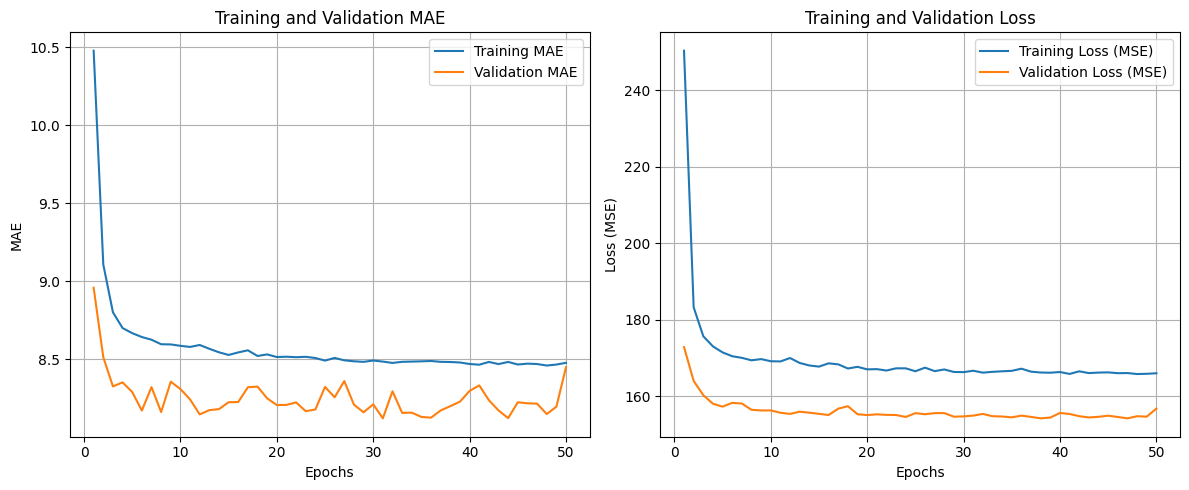

301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step

Model ANN Regresi Evaluation on Test Data:
MAE:  8.4504
MSE:  156.7904
RMSE: 12.5216
R²:   0.6153


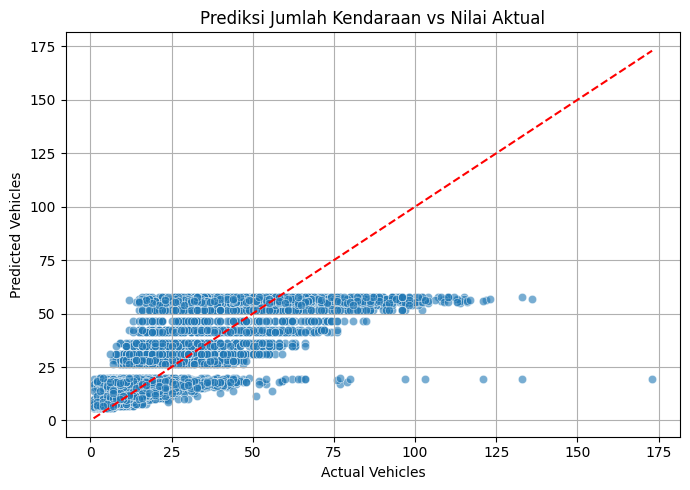


Model ANN Regresi Training Data Size: 38496
Model ANN Regresi Final Training Loss (MSE): 166.0305
Model ANN Regresi Final Validation Loss (MSE): 156.7904
Model ANN Regresi Final Training MAE: 8.4786
Model ANN Regresi Final Validation MAE: 8.4504


In [75]:
# Fit dan Evaluasi Model ANN Regresi

# Melatih model
history = model_1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Plot MAE dan Loss selama training
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(mae) + 1)

plt.figure(figsize=(12, 5))

# Subplot MAE
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend(loc='upper right')
plt.grid(True)

# Subplot Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss (MSE)')
plt.plot(epochs_range, val_loss, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluasi dan visualisasi hasil prediksi
evaluate_and_plot_regression(
    model=model_1,
    x_test=X_test,
    y_test=y_test,
    model_name="Model ANN Regresi",
    title="Prediksi Jumlah Kendaraan vs Nilai Aktual",
    history=history,
    x_train=X_train,
    y_train=y_train
)



In [71]:
model_1.save('simpanmodel.h5')


c:\Users\muhamad fajar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,441 (5.63 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 392.6943 - mae: 12.9824 - val_loss: 159.8922 - val_mae: 8.7430
Epoch 2/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 170.8422 - mae: 8.9994 - val_loss: 146.2402 - val_mae: 8.3177
Epoch 3/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 158.5888 - mae: 8.6120 - val_loss: 140.8802 - val_mae: 8.1507
Epoch 4/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 155.6990 - mae: 8.5122 - val_loss: 138.4825 - val_mae: 8.0976
Epoch 5/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 152.5509 - mae: 8.4231 - val_loss: 134.3787 - val_mae: 7.9737
Epoch 6/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 150.0347 - mae: 8.3830 - val_loss: 132.3733 - val_mae: 7.9497
Epoch 7/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 146.0536 - mae: 8.2646 - val_loss: 129.2858 - val_mae: 7.8238
Epoch 8/50
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 143.0127 - mae: 8.1693 - val_loss: 128.3333 - val_mae: 7.7480
Epoch 9

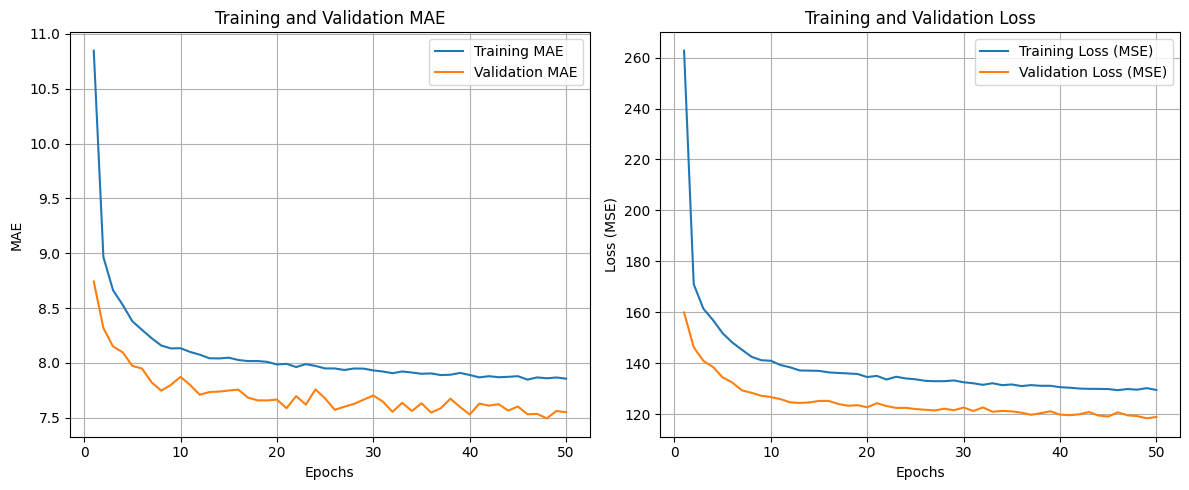

301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step

Model ANN Regresi Evaluation on Test Data:
MAE:  7.5519
MSE:  118.8271
RMSE: 10.9008
R²:   0.7084


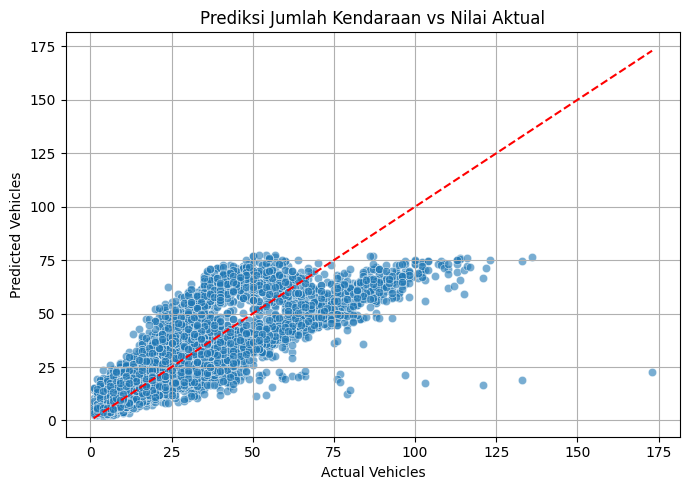


Model ANN Regresi Training Data Size: 38496
Model ANN Regresi Final Training Loss (MSE): 129.4396
Model ANN Regresi Final Validation Loss (MSE): 118.8271
Model ANN Regresi Final Training MAE: 7.8570
Model ANN Regresi Final Validation MAE: 7.5519


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam, AdamW
import plotly.express as px

# Load the traffic data
df = pd.read_csv('traffic.csv')  # Adjust path if needed

# Feature engineering - extracting features from DateTime
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Hour'] = df['DateTime'].dt.hour
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

# Preparing features and target variables
# Using Junction, Hour, Day, Month, DayOfWeek as features
# Using Vehicles as the target variable
X = df[['Junction', 'Hour', 'Day', 'Month', 'DayOfWeek']]
y = df['Vehicles']

# Fungsi untuk split dan normalisasi data
def split_data(x, y):
    # Using 80% training data, 20% test data
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, Y_train, Y_test

# Fungsi untuk membuat dan mengkompilasi model ANN
def init_ann(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(1, activation='linear'))  # Output regresi
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
    return model

# Fungsi untuk mengevaluasi model dan membuat plot
def evaluate_and_plot_regression(model, x_test, y_test, model_name, title, history, x_train, y_train):
    y_pred = model.predict(x_test).flatten()
    y_test = np.array(y_test).flatten()

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name} Evaluation on Test Data:")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    plt.xlabel("Actual Vehicles")
    plt.ylabel("Predicted Vehicles")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\n{model_name} Training Data Size: {len(x_train)}")
    print(f"{model_name} Final Training Loss (MSE): {history.history['loss'][-1]:.4f}")
    print(f"{model_name} Final Validation Loss (MSE): {history.history['val_loss'][-1]:.4f}")
    print(f"{model_name} Final Training MAE: {history.history['mae'][-1]:.4f}")
    print(f"{model_name} Final Validation MAE: {history.history['val_mae'][-1]:.4f}")

def optimizer():
    sgd = SGD(learning_rate=0.005, momentum=0.5, nesterov=True)
    rms = RMSprop()
    nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    adam = Adam()
    adamW = AdamW(learning_rate=0.002, weight_decay=0.001, beta_1=0.9, beta_2=0.999)
    return sgd, rms, nadam, adamW, adam

# Visualisasi proporsi data
def plot_data_split_pie(train_size, test_size_count):
    sizes = [train_size, test_size_count]
    labels = ['Data Latih', 'Data Uji']

    fig = px.pie(values=sizes, names=labels, title='Proporsi Data Latih dan Data Uji',
                 hover_data={'values': sizes}, labels={'values': 'Jumlah'})
    fig.update_traces(textinfo='percent+label', hovertemplate='Jumlah: %{value}<br>Persentase: %{percent}')

    fig.add_annotation(
        x=0.5, y=-0.1,
        text=f"Data Latih (80%) sebanyak {train_size} data, dan data uji (20%) sebanyak {test_size_count} data",
        showarrow=False,
        xref="paper", yref="paper",
        font=dict(size=12),
        align="center"
    )

    fig.show()  # Changed to show() instead of write_html() for interactive viewing
    # Optionally save: fig.write_html("data_split.html")

# Split the data with 80% training data
X_train, X_test, y_train, y_test = split_data(X, y)

# Calculate sizes for visualization
train_size = len(X_train)
test_size_count = len(X_test)

# Visualize the data split
plot_data_split_pie(train_size, test_size_count)

# Initialize the model
model_1 = init_ann(input_dim=X_train.shape[1])
model_1.summary()

# Train the model
history = model_1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Plot MAE and Loss during training
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(mae) + 1)

plt.figure(figsize=(12, 5))

# Subplot MAE
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend(loc='upper right')
plt.grid(True)

# Subplot Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss (MSE)')
plt.plot(epochs_range, val_loss, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate and visualize prediction results
evaluate_and_plot_regression(
    model=model_1,
    x_test=X_test,
    y_test=y_test,
    model_name="Model ANN Regresi",
    title="Prediksi Jumlah Kendaraan vs Nilai Aktual",
    history=history,
    x_train=X_train,
    y_train=y_train
)

model_1.save('simpanmodel.h5')